This notebook performs a detailed analysis of the Principal Component Analysis (PCA)
for trajectory compression, mirroring the analysis in the MotionDiffuser paper.
It determines how many principal components are needed to faithfully represent
the trajectory data by plotting the reconstruction error.

In [1]:
import os
import sys
import torch
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import multiprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Setup ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config

In [56]:
# --- Helper Functions ---

def normalize_trajectory(trajectory, stats):
    """
    Normalizes an (x, y) trajectory to the [-1, 1] range using isotropic stats.
    The input `trajectory` should be a torch.Tensor.
    The input `stats` is the dictionary loaded from normalization_stats.pt.
    """
    # Using stats['min'] and stats['max'] which are single scalar values for isotropic scaling
    return 2 * (trajectory - stats['min']) / (stats['max'] - stats['min']) - 1

def denormalize_trajectory(trajectory, stats):
    """
    De-normalizes an (x, y) trajectory from the [-1, 1] range back to the
    original meter scale using isotropic stats.
    The input `trajectory` should be a torch.Tensor.
    The input `stats` is the dictionary loaded from normalization_stats.pt.
    """
    # Using stats['min'] and stats['max'] which are single scalar values for isotropic scaling
    return ((trajectory + 1) / 2) * (stats['max'] - stats['min']) + stats['min']

def _load_and_normalize_trajectory(args):
    """Helper for parallel processing. Loads, normalizes, and flattens a trajectory."""
    path, stats = args
    try:
        sample = torch.load(path, map_location='cpu', weights_only=False)
        traj_meters = torch.from_numpy(sample['target_trajectory'][:, :2])
        traj_normalized = normalize_trajectory(traj_meters, stats)
        return traj_normalized.flatten().numpy()
    except Exception:
        return None

In [ ]:
# ==============================================================================
# --- Main Analysis Script ---
# ==============================================================================
print("--- Starting PCA Component Analysis ---")

# 1. Load Config, Stats, and Data Paths
config = load_config(os.path.join(PROJECT_ROOT, 'configs/main_config.yaml'))
stats_path = os.path.join(PROJECT_ROOT, 'models', 'normalization_stats.pt')
stats = torch.load(stats_path)
train_files = glob(os.path.join(config['data']['featurized_dir'], 'training', '*.pt'))

# 2. Load and Prepare All Training Trajectories in Parallel
print(f"Loading and normalizing {len(train_files)} trajectories...")
map_args = [(path, stats) for path in train_files]
with multiprocessing.Pool(processes=os.cpu_count()) as pool:
    results_iterator = pool.imap_unordered(_load_and_normalize_trajectory, map_args)
    pbar = tqdm(results_iterator, total=len(train_files), desc="Loading trajectories")
    flattened_trajectories = [traj for traj in pbar if traj is not None]

data_matrix = np.stack(flattened_trajectories, axis=0)
print(f"Created data matrix of shape: {data_matrix.shape}")

--- Starting PCA Component Analysis ---
Configuration loaded successfully.
Loading and normalizing 227745 trajectories...


Loading trajectories:   0%|          | 0/227745 [00:00<?, ?it/s]

Created data matrix of shape: (227745, 160)


In [8]:
# 3. Define the experiment parameters
# We will test a range of n_components values
components_to_test = [1, 2, 4, 6, 8, 10, 12, 16, 24, 32]

# Create lists to store all metrics
reconstruction_errors_mean = []
reconstruction_errors_std = [] # <-- NEW
explained_variances = []

for n_components in tqdm(components_to_test, desc="Fitting PCA models"):
    pca = PCA(n_components=n_components)
    latent_vectors = pca.fit_transform(data_matrix)
    reconstructed_matrix = pca.inverse_transform(latent_vectors)
    
    # --- Calculate Metrics ---
    explained_variance = pca.explained_variance_ratio_.sum()
    explained_variances.append(explained_variance)
    
    original_trajs = data_matrix.reshape(-1, 80, 2)
    reconstructed_trajs = reconstructed_matrix.reshape(-1, 80, 2)
    
    errors = np.linalg.norm(original_trajs - reconstructed_trajs, axis=-1)
    
    meter_range = (stats['max'] - stats['min']).item()
    error_in_meters = (errors / 2) * meter_range
    
    # --- NEW: Calculate both mean and std of the per-waypoint error ---
    avg_error = np.mean(error_in_meters)
    std_error = np.std(error_in_meters) # <-- NEW
    
    reconstruction_errors_mean.append(avg_error)
    reconstruction_errors_std.append(std_error) # <-- NEW
    
    print(f"n_components={n_components:2d} | Explained Variance={explained_variance:.4f} | "
          f"Avg. Error={avg_error:.4f} m | Std. Dev Error={std_error:.4f} m")



Fitting PCA models:   0%|          | 0/10 [00:00<?, ?it/s]

n_components= 1 | Explained Variance=0.9153 | Avg. Error=3.7841 m | Std. Dev Error=6.1151 m
n_components= 2 | Explained Variance=0.9791 | Avg. Error=2.3168 m | Std. Dev Error=2.1567 m
n_components= 4 | Explained Variance=0.9992 | Avg. Error=0.5644 m | Std. Dev Error=0.6114 m
n_components= 6 | Explained Variance=0.9999 | Avg. Error=0.2413 m | Std. Dev Error=0.2834 m
n_components= 8 | Explained Variance=1.0000 | Avg. Error=0.1652 m | Std. Dev Error=0.2600 m
n_components=10 | Explained Variance=1.0000 | Avg. Error=0.1450 m | Std. Dev Error=0.2599 m
n_components=12 | Explained Variance=1.0000 | Avg. Error=0.1384 m | Std. Dev Error=0.2609 m
n_components=16 | Explained Variance=1.0000 | Avg. Error=0.1362 m | Std. Dev Error=0.2613 m
n_components=24 | Explained Variance=1.0000 | Avg. Error=0.1360 m | Std. Dev Error=0.2613 m
n_components=32 | Explained Variance=1.0000 | Avg. Error=0.1357 m | Std. Dev Error=0.2613 m



--- Plotting Results ---


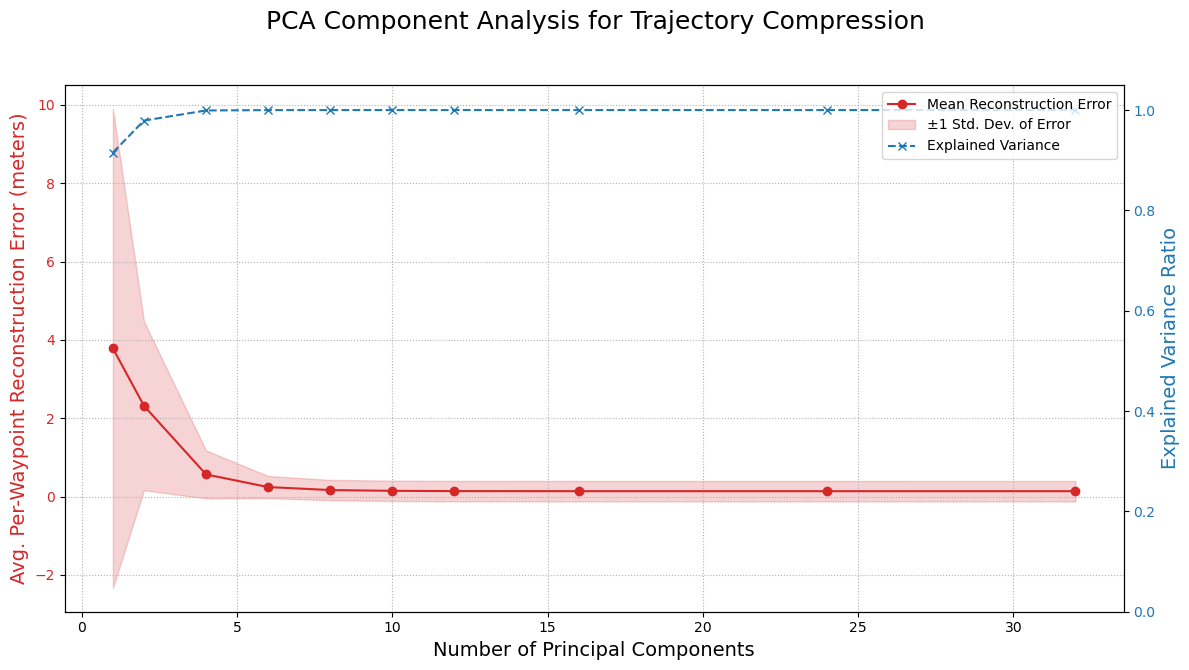

In [9]:
# --- 5. Plot the Results (Updated to show error bands) ---
print("\n--- Plotting Results ---")
fig, ax1 = plt.subplots(figsize=(12, 7)) # Slightly wider plot

# Convert lists to numpy arrays for easier calculations
mean_errors = np.array(reconstruction_errors_mean)
std_errors = np.array(reconstruction_errors_std)

# Plot Reconstruction Error on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Number of Principal Components', fontsize=14)
ax1.set_ylabel('Avg. Per-Waypoint Reconstruction Error (meters)', color=color, fontsize=14)
ax1.plot(components_to_test, mean_errors, color=color, marker='o', label='Mean Reconstruction Error')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle=':')

# --- NEW: Add the shaded error band for the standard deviation ---
ax1.fill_between(
    components_to_test,
    mean_errors - std_errors,
    mean_errors + std_errors,
    alpha=0.2, color=color, label='±1 Std. Dev. of Error'
)

# Create a second y-axis for Explained Variance
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Explained Variance Ratio', color=color, fontsize=14)
ax2.plot(components_to_test, explained_variances, color=color, marker='x', linestyle='--', label='Explained Variance')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.05)

fig.suptitle('PCA Component Analysis for Trajectory Compression', fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Collect handles and labels from both axes for a single, unified legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()


--- Visualizing the Top Principal Components ---
Fitting a single PCA model with 10 components...
Model fitted.


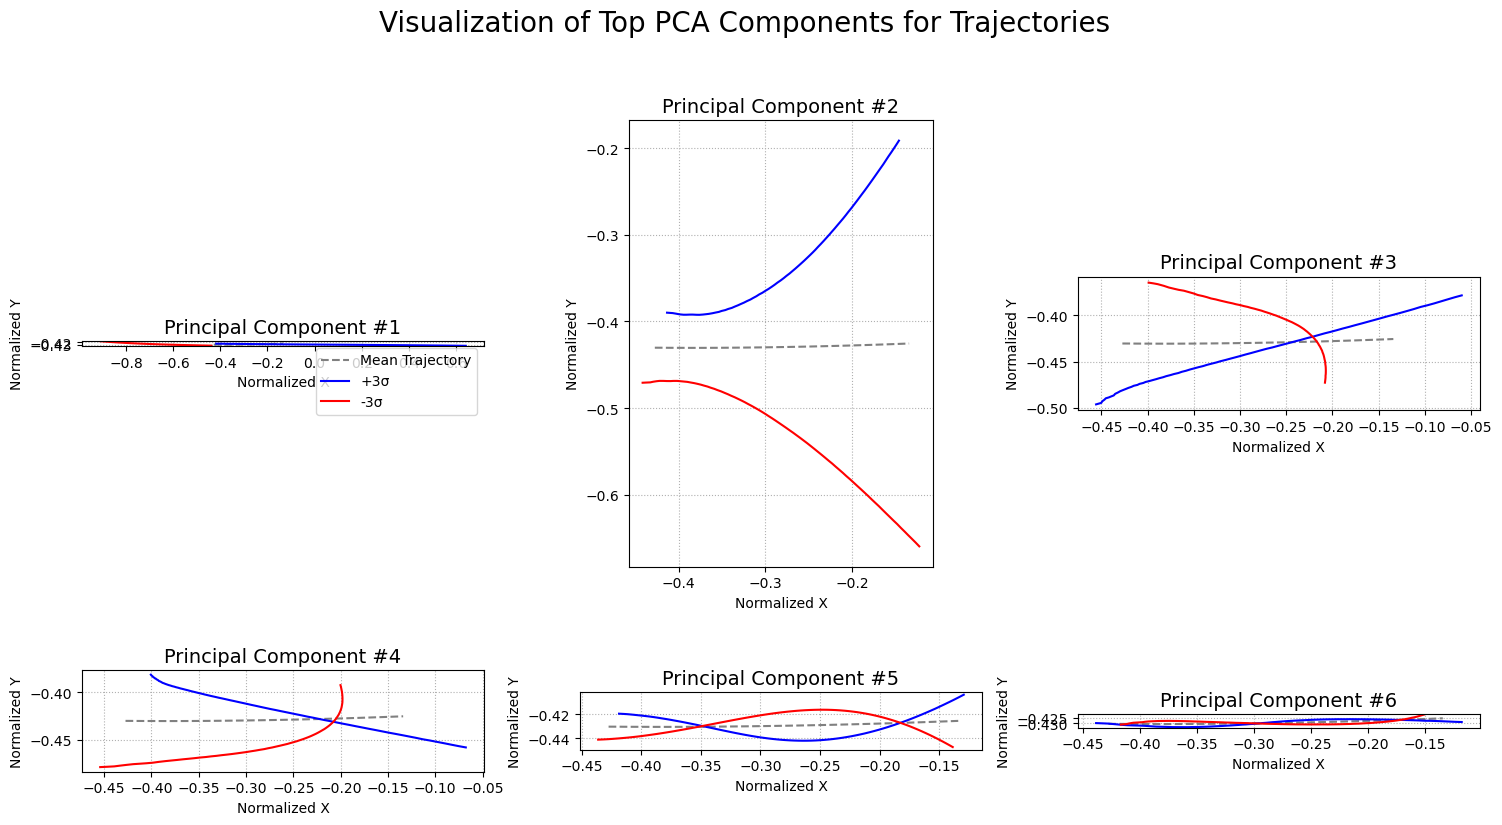

In [10]:
# ==============================================================================
# --- Section 6: Visualize the Principal Components ---
# ==============================================================================
print("\n--- Visualizing the Top Principal Components ---")

# 1. Fit a single, high-quality PCA model to get the components
N_COMPONENTS_TO_VISUALIZE = 10 # Let's visualize the top 10
print(f"Fitting a single PCA model with {N_COMPONENTS_TO_VISUALIZE} components...")

pca_viz = PCA(n_components=N_COMPONENTS_TO_VISUALIZE)
pca_viz.fit(data_matrix)
print("Model fitted.")

# 2. Extract the mean and the components from the fitted model
mean_trajectory_flat = pca_viz.mean_
principal_components_flat = pca_viz.components_

# Reshape them back into trajectory format (80, 2)
mean_trajectory = mean_trajectory_flat.reshape(80, 2)
principal_components = principal_components_flat.reshape(N_COMPONENTS_TO_VISUALIZE, 80, 2)

# 3. Create the Visualization
# We'll create a plot showing the mean trajectory and the effect of +/- 3 standard deviations
# for each of the top components. The standard deviation in the latent space is given by `sqrt(explained_variance)`.
latent_std_devs = np.sqrt(pca_viz.explained_variance_)

# Create a subplot grid
# Let's visualize the top 6 components for clarity
num_to_plot = 6
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_to_plot):
    ax = axes[i]
    
    # Get the specific component and its standard deviation
    component = principal_components[i]
    std_dev = latent_std_devs[i]
    
    # Plot the mean trajectory in gray as a reference
    ax.plot(mean_trajectory[:, 0], mean_trajectory[:, 1], color='gray', linestyle='--', label='Mean Trajectory')
    
    # Show the effect of adding the component
    traj_plus = mean_trajectory + 3 * std_dev * component
    ax.plot(traj_plus[:, 0], traj_plus[:, 1], color='blue', label='+3σ')

    # Show the effect of subtracting the component
    traj_minus = mean_trajectory - 3 * std_dev * component
    ax.plot(traj_minus[:, 0], traj_minus[:, 1], color='red', label='-3σ')

    ax.set_title(f'Principal Component #{i+1}', fontsize=14)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle=':')
    ax.set_xlabel('Normalized X')
    ax.set_ylabel('Normalized Y')
    if i == 0:
        ax.legend()

fig.suptitle('Visualization of Top PCA Components for Trajectories', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Generating a single, overlaid plot of the top PCA components ---
Fitting PCA model first...


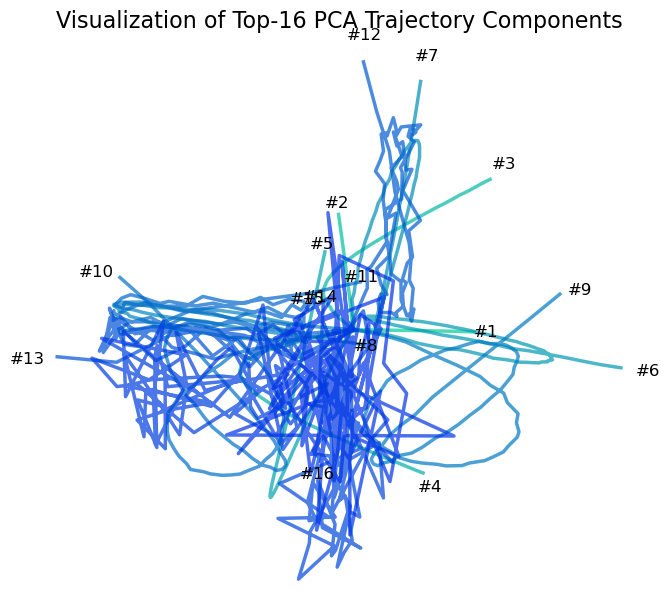

In [44]:
# ==============================================================================
# --- Section 7: Replicating the MotionDiffuser PCA Visualization ---
# ==============================================================================
print("\n--- Generating a single, overlaid plot of the top PCA components ---")

# 1. Fit PCA model (if not already done)
print("Fitting PCA model first...")
N_COMPONENTS_TO_VISUALIZE = 16
pca_viz = PCA(n_components=N_COMPONENTS_TO_VISUALIZE)
pca_viz.fit(data_matrix)

# 2. Extract the components and reshape them
principal_components_flat = pca_viz.components_
principal_components = principal_components_flat.reshape(N_COMPONENTS_TO_VISUALIZE, 80, 2)


# 2. Create the single plot
fig, ax = plt.subplots(figsize=(8, 10))

# Use a color gradient
colors = plt.cm.winter_r(np.linspace(0.2, 0.8, N_COMPONENTS_TO_VISUALIZE))

endpoint_dist_target = 1.0 # Target distance for the first component's endpoint
pc1_endpoint_dist = np.linalg.norm(principal_components[0, -1, :])
scaling_factor = endpoint_dist_target / pc1_endpoint_dist

# 4. Plot each scaled component, starting from the origin
for i in range(N_COMPONENTS_TO_VISUALIZE):
    # The component itself represents a shape of deviation from the mean.
    # We scale it for visibility and plot it directly.
    component_trajectory = principal_components[i] * scaling_factor
    
    # We can choose to align the starting point to (0,0) for a cleaner plot,
    # just like the paper's visualization.
    start_point = component_trajectory[0, :]
    component_trajectory_aligned = component_trajectory - start_point
    
    ax.plot(
        component_trajectory_aligned[:, 0], 
        component_trajectory_aligned[:, 1], 
        color=colors[i],
        linewidth=2.5,
        alpha=0.7
    )
    
    # Add a text label near the endpoint of the trajectory
    endpoint = component_trajectory_aligned[-1]
    ax.text(endpoint[0] * 1.1, endpoint[1] * 1.1, f'#{i+1}', fontsize=12, ha='center', va='center')

# --- Final Aesthetics to Match the Paper ---
ax.set_title(f'Visualization of Top-{N_COMPONENTS_TO_VISUALIZE} PCA Trajectory Components', fontsize=16)

# Hide axis labels and ticks for a cleaner, more abstract look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_aspect('equal', adjustable='box')
plt.show()


--- Visualizing the 'Anatomy' of Specific Trajectories ---
Fitting a final PCA model with 16 components...
Model fitted.


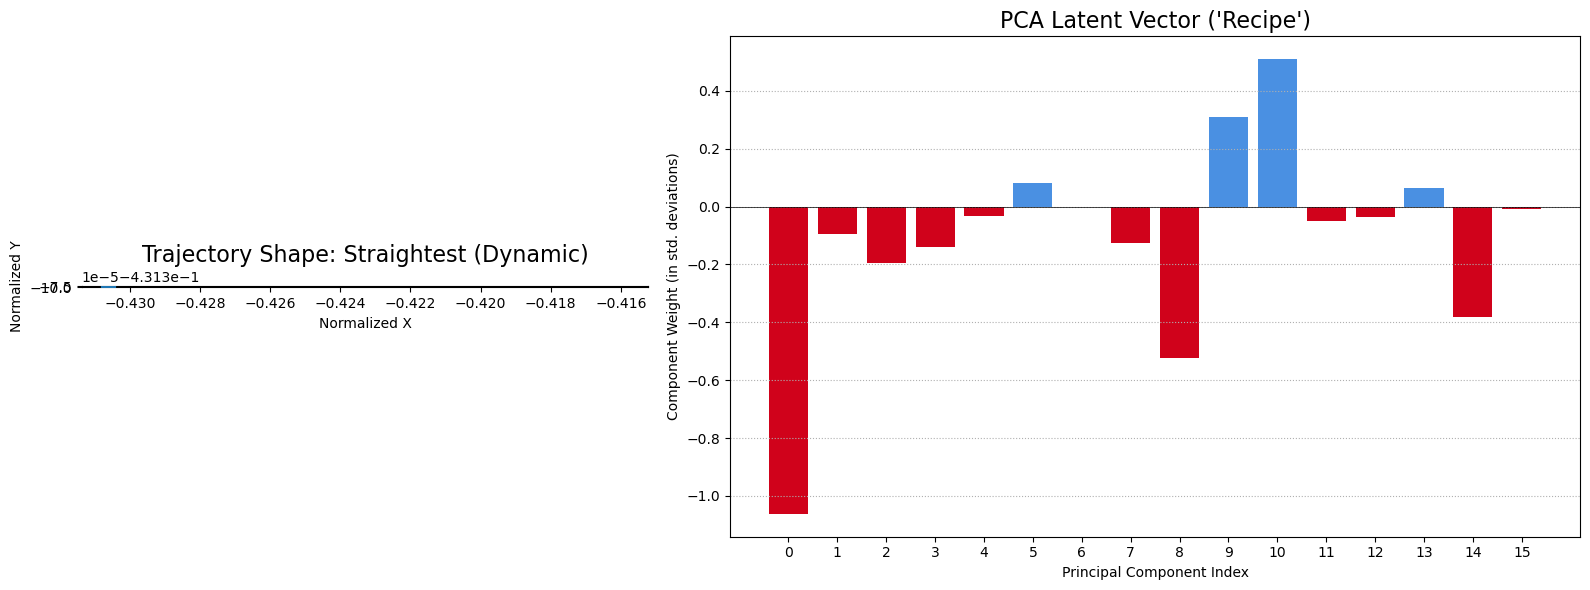

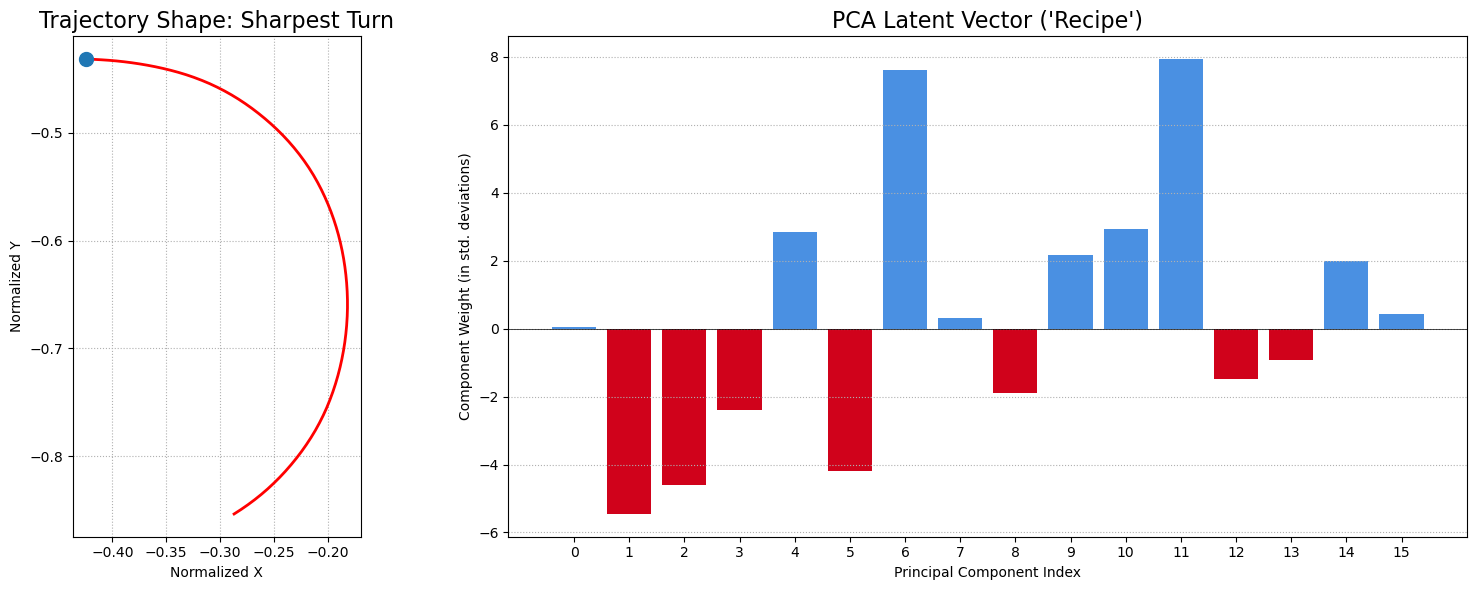

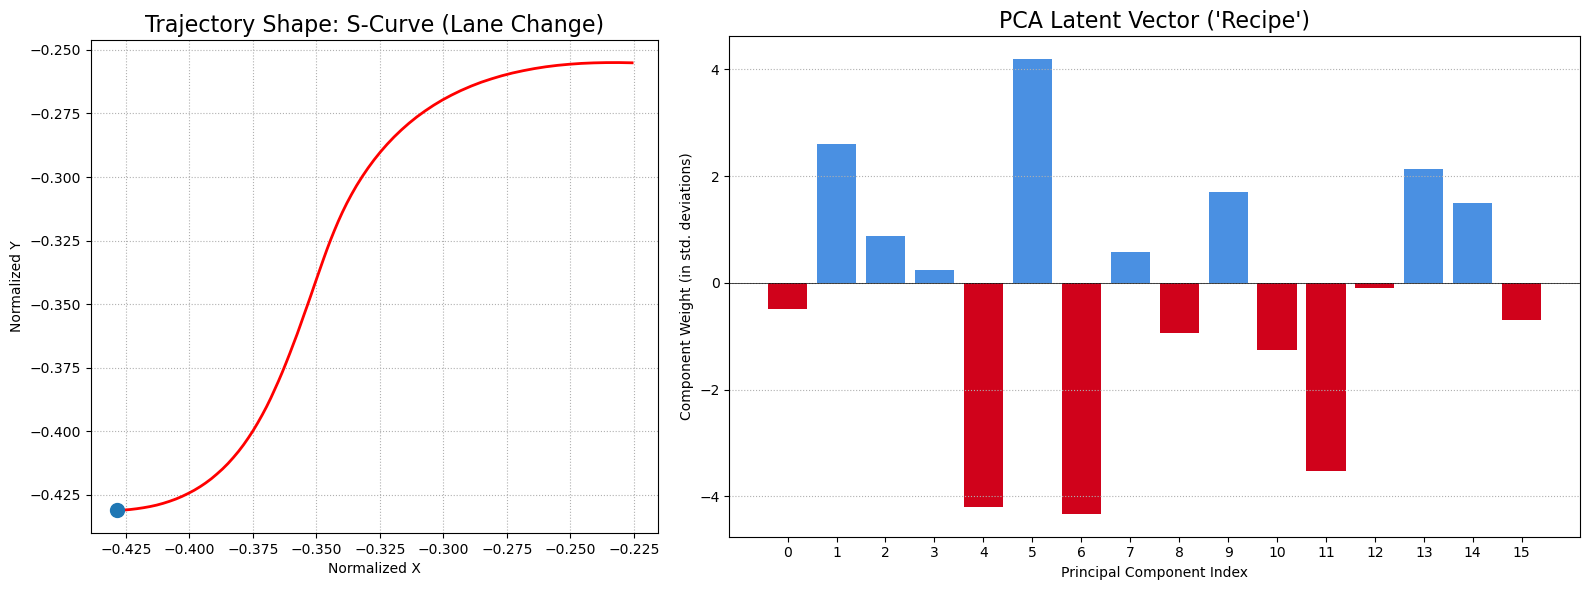

In [58]:
# ==============================================================================
# --- Section 7: Anatomy of a Trajectory (Interpreting the Latent Space) ---
# ==============================================================================
print("\n--- Visualizing the 'Anatomy' of Specific Trajectories ---")

# We will use the PCA model we already fitted in the previous visualization cell.
# Let's ensure it's the right one.
N_COMPONENTS_FOR_ANATOMY = 16
print(f"Fitting a final PCA model with {N_COMPONENTS_FOR_ANATOMY} components...")
pca_final = PCA(n_components=N_COMPONENTS_FOR_ANATOMY, whiten=True)
pca_final.fit(data_matrix)
print("Model fitted.")

def perpendicular_distance_to_line(points, line_start, line_end):
    """
    Calculates the perpendicular distance of a set of points to a line segment.
    Vectorized for performance.
    """
    line_vec = line_end - line_start
    point_vec = points - line_start
    
    line_len_sq = np.sum(line_vec**2)
    # Handle zero-length lines (start == end)
    if line_len_sq < 1e-8:
        return np.linalg.norm(point_vec, axis=-1)
        
    # Project point_vec onto line_vec
    t = np.dot(point_vec, line_vec) / line_len_sq
    
    # Find the closest point on the infinite line
    closest_points = line_start + t[..., np.newaxis] * line_vec
    
    # Return the distance
    return np.linalg.norm(points - closest_points, axis=-1)

def signed_perpendicular_distance_to_line(points, line_start, line_end):
    """
    Calculates the SIGNED perpendicular distance of points to a line segment.
    Positive means "left" of the line, negative means "right".
    """
    line_vec = line_end - line_start
    
    # Handle zero-length lines
    if np.linalg.norm(line_vec) < 1e-8:
        return np.zeros(len(points))
        
    # Perpendicular vector (rotated 90 degrees counter-clockwise)
    perp_vec = np.array([-line_vec[1], line_vec[0]])
    perp_vec_normalized = perp_vec / np.linalg.norm(perp_vec)
    
    point_vecs = points - line_start
    
    # Project point vectors onto the normalized perpendicular vector
    # The dot product gives the signed distance.
    signed_distances = np.dot(point_vecs, perp_vec_normalized)
    return signed_distances

# --- Helper function to find interesting trajectories ---
def find_interesting_trajectories(trajectories_flat, num_samples=40000, min_displacement=2.0):
    """
    Finds trajectories with specific characteristics for visualization.
    --- FINAL, MOST ROBUST VERSION ---
    """
    indices = np.random.choice(len(trajectories_flat), num_samples, replace=False)
    trajectories = trajectories_flat[indices].reshape(-1, 80, 2)
    
    # --- Pre-filter for meaningful movement ---
    start_points = trajectories[:, 0, :]
    end_points = trajectories[:, -1, :]
    displacements = np.linalg.norm(end_points - start_points, axis=1)
    
    meter_range = (stats['max'] - stats['min']).item()
    normalized_displacement_threshold = (min_displacement / meter_range) * 2
    moving_mask = displacements > normalized_displacement_threshold
    
    moving_trajectories = trajectories[moving_mask]
    moving_indices = indices[moving_mask]
    
    if len(moving_trajectories) == 0:
        raise ValueError(f"No trajectories found with displacement > {min_displacement}m.")

    # --- Analysis on moving trajectories ---
    start_points_moving = moving_trajectories[:, 0, :]
    end_points_moving = moving_trajectories[:, -1, :]
    
    # Heuristic for "straightest" and "sharpest turn": Max perpendicular deviation
    deviations = np.array([
        np.max(np.abs(signed_perpendicular_distance_to_line(traj, start, end)))
        for traj, start, end in zip(moving_trajectories, start_points_moving, end_points_moving)
    ])
    
    straightest_subset_idx = np.argmin(deviations)
    straightest_idx = moving_indices[straightest_subset_idx]
    
    sharpest_turn_subset_idx = np.argmax(deviations)
    sharpest_turn_idx = moving_indices[sharpest_turn_subset_idx]
    
    # --- NEW: Heuristic for "S-curve" using signed distance ---
    # Calculate min (most negative) and max (most positive) signed deviations for each trajectory
    signed_devs = np.array([
        signed_perpendicular_distance_to_line(traj, start, end)
        for traj, start, end in zip(moving_trajectories, start_points_moving, end_points_moving)
    ])
    
    max_pos_devs = np.max(signed_devs, axis=1)
    min_neg_devs = np.min(signed_devs, axis=1)
    
    # The "S-ness" score is the product of the max positive and max negative (absolute) deviation.
    # This score is high only if the trajectory deviates significantly on BOTH sides of its average path.
    s_curve_scores = max_pos_devs * np.abs(min_neg_devs)
    
    s_curve_subset_idx = np.argmax(s_curve_scores)
    s_curve_idx = moving_indices[s_curve_subset_idx]

    return {
        "Straightest (Dynamic)": straightest_idx,
        "Sharpest Turn": sharpest_turn_idx,
        "S-Curve (Lane Change)": s_curve_idx
    }

# --- Find some example trajectories to analyze ---
interesting_indices = find_interesting_trajectories(data_matrix)

# --- Create the plots ---
for title, idx in interesting_indices.items():
    # 1. Get the specific trajectory and its latent vector
    trajectory_flat = data_matrix[idx]
    trajectory_2d = trajectory_flat.reshape(80, 2)
    
    # The latent vector is the "recipe"
    latent_vector = pca_final.transform(trajectory_flat.reshape(1, -1)).squeeze()
    
    # 2. Create the two-part figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1.5]})
    
    # --- Plot 1: The Trajectory Shape ---
    ax1.plot(trajectory_2d[:, 0], trajectory_2d[:, 1], 'r-', linewidth=2)
    ax1.scatter(trajectory_2d[0, 0], trajectory_2d[0, 1], marker='o', s=100, label='Start', zorder=10)
    ax1.set_title(f"Trajectory Shape: {title}", fontsize=16)
    ax1.set_xlabel('Normalized X')
    ax1.set_ylabel('Normalized Y')
    ax1.set_aspect('equal', adjustable='box')
    ax1.grid(True, linestyle=':')
    
    # --- Plot 2: The Latent Vector "Recipe" ---
    component_indices = np.arange(N_COMPONENTS_FOR_ANATOMY)
    colors = ['#4A90E2' if val >= 0 else '#D0021B' for val in latent_vector]
    ax2.bar(component_indices, latent_vector, color=colors)
    ax2.set_title(f"PCA Latent Vector ('Recipe')", fontsize=16)
    ax2.set_xlabel('Principal Component Index')
    ax2.set_ylabel('Component Weight (in std. deviations)')
    ax2.axhline(0, color='black', linewidth=0.5)
    ax2.set_xticks(component_indices)
    ax2.grid(True, axis='y', linestyle=':')
    
    plt.tight_layout()
    plt.show()


--- Visualizing Trajectory Interpolation in the PCA Latent Space ---


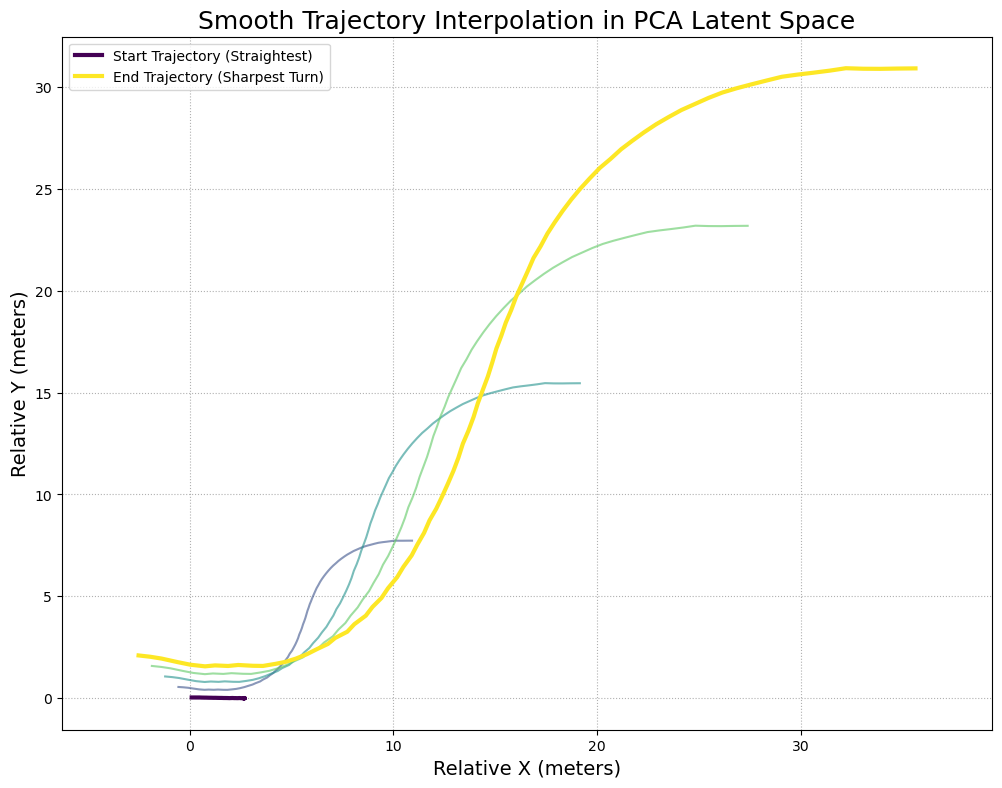

In [61]:
# ==============================================================================
# --- Section 8: Latent Space Trajectory Explorer ---
# ==============================================================================
print("\n--- Visualizing Trajectory Interpolation in the PCA Latent Space ---")

# We will use the final PCA model from the previous section (pca_final)

# 1. Select two distinct "endpoint" trajectories for our interpolation.
# We'll use the "straightest" and "sharpest turn" trajectories we found earlier.
start_idx = interesting_indices["Straightest (Dynamic)"]
end_idx = interesting_indices["S-Curve (Lane Change)"]

# Get the flattened, normalized trajectory data for these two samples
start_traj_flat = data_matrix[start_idx].reshape(1, -1)
end_traj_flat = data_matrix[end_idx].reshape(1, -1)

# 2. Transform these trajectories into their latent vectors using our PCA model
z_start = pca_final.transform(start_traj_flat)
z_end = pca_final.transform(end_traj_flat)

# 3. Linearly interpolate between these two points in the 16D latent space
N_INTERPOLATION_STEPS =5 
interpolation_weights = np.linspace(0, 1, N_INTERPOLATION_STEPS)
interpolated_latents = []
for alpha in interpolation_weights:
    z_interp = (1 - alpha) * z_start + alpha * z_end
    interpolated_latents.append(z_interp)

interpolated_latents = np.concatenate(interpolated_latents, axis=0)

# 4. Inverse transform the interpolated latent vectors back into trajectory space
reconstructed_trajectories_flat = pca_final.inverse_transform(interpolated_latents)
reconstructed_trajectories = reconstructed_trajectories_flat.reshape(N_INTERPOLATION_STEPS, 80, 2)

# 5. De-normalize all trajectories back to meters for plotting
start_traj_meters = denormalize_trajectory(torch.from_numpy(start_traj_flat.reshape(80, 2)), stats).numpy()
end_traj_meters = denormalize_trajectory(torch.from_numpy(end_traj_flat.reshape(80, 2)), stats).numpy()
interpolated_trajs_meters = [
    denormalize_trajectory(torch.from_numpy(traj), stats).numpy() for traj in reconstructed_trajectories
]

# 6. Create the final visualization
plt.figure(figsize=(12, 9))

# Plot the interpolated trajectories with a color gradient
# The colormap will go from one color to another to show the "morph"
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in interpolation_weights]

for i, traj in enumerate(interpolated_trajs_meters):
    if i == 0:
        # Make the start trajectory thicker and more prominent
        plt.plot(traj[:, 0], traj[:, 1], color=colors[i], linewidth=3, label='Start Trajectory (Straightest)')
    elif i == N_INTERPOLATION_STEPS - 1:
        # Make the end trajectory thicker and more prominent
        plt.plot(traj[:, 0], traj[:, 1], color=colors[i], linewidth=3, label='End Trajectory (Sharpest Turn)')
    else:
        # Interpolated trajectories are thinner
        plt.plot(traj[:, 0], traj[:, 1], color=colors[i], linewidth=1.5, alpha=0.6)

plt.title('Smooth Trajectory Interpolation in PCA Latent Space', fontsize=18)
plt.xlabel('Relative X (meters)', fontsize=14)
plt.ylabel('Relative Y (meters)', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.show()


--- Visualizing the Distribution of the Entire Dataset in PCA Latent Space ---
Transforming all 227745 training samples into the latent space...
Created latent vector matrix of shape: (227745, 16)

Latent Space Mean (first 5 components): [-0.00011126 -0.00799214  0.01600988 -0.02110151 -0.00668883]
Latent Space Std Dev (first 5 components): [0.9998383  0.92026097 0.7322912  0.8417181  0.99482536]
Note: If whiten=True was used, means should be near 0 and std devs near 1.


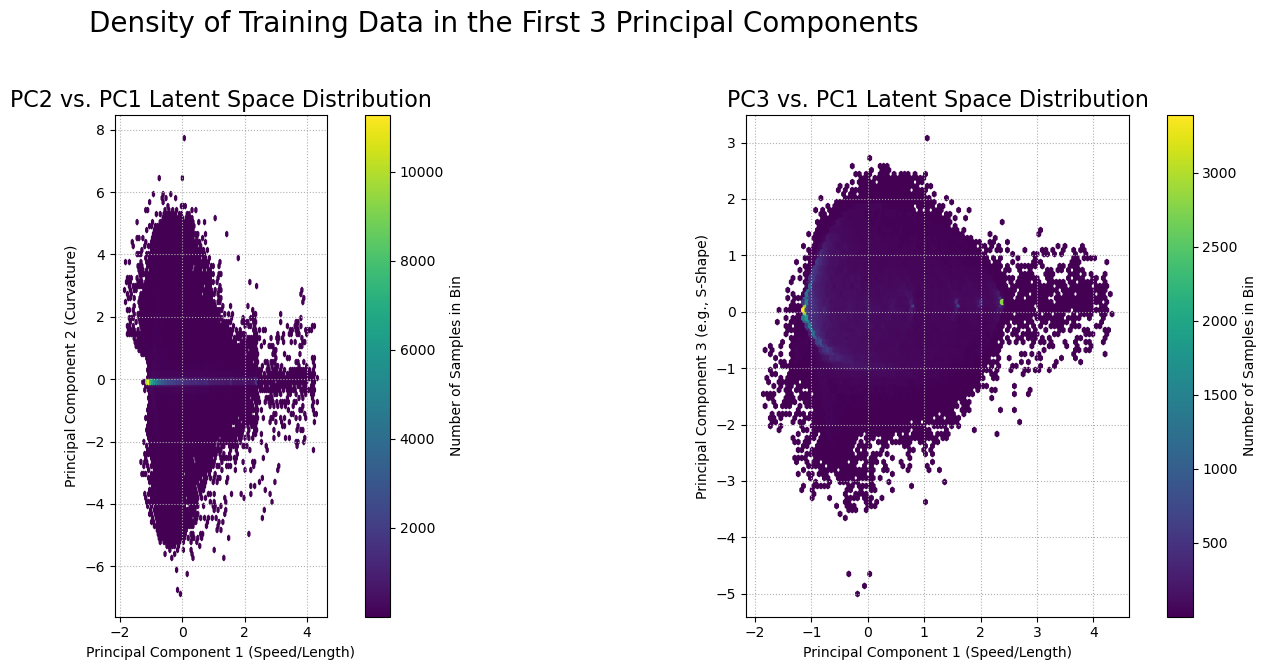

In [62]:
# ==============================================================================
# --- Section 9: Distribution of Latent Space ---
# ==============================================================================
print("\n--- Visualizing the Distribution of the Entire Dataset in PCA Latent Space ---")

# We will use the final PCA model (pca_final) and the full data_matrix from previous cells.

# 1. Transform the entire training dataset into the latent space
print(f"Transforming all {len(data_matrix)} training samples into the latent space...")
# This will be very fast as the PCA model is already fitted.
all_latent_vectors = pca_final.transform(data_matrix)
print(f"Created latent vector matrix of shape: {all_latent_vectors.shape}")

# 2. Analyze the statistics of the latent space
# If `whiten=True` was used, the mean should be ~0 and the variance ~1 for each component.
latent_mean = np.mean(all_latent_vectors, axis=0)
latent_std = np.std(all_latent_vectors, axis=0)
print(f"\nLatent Space Mean (first 5 components): {latent_mean[:5]}")
print(f"Latent Space Std Dev (first 5 components): {latent_std[:5]}")
print("Note: If whiten=True was used, means should be near 0 and std devs near 1.")


# 3. Create the visualizations
# It's most informative to see the relationship between the first few, most important components.
# We will create a scatter plot of PC1 vs PC2 and PC1 vs PC3.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: Principal Component 1 vs. Principal Component 2 ---
# Using a 2D histogram (hexbin) is better than a scatter plot for this many points,
# as it shows density instead of just a black blob of overplotted points.
# The 'viridis' colormap will show dense areas in yellow and sparse areas in purple.
hex_plot = ax1.hexbin(
    all_latent_vectors[:, 0], 
    all_latent_vectors[:, 1], 
    gridsize=100, 
    cmap='viridis',
    mincnt=1 # Don't show bins with zero points
)
fig.colorbar(hex_plot, ax=ax1, label='Number of Samples in Bin')
ax1.set_title('PC2 vs. PC1 Latent Space Distribution', fontsize=16)
ax1.set_xlabel('Principal Component 1 (Speed/Length)')
ax1.set_ylabel('Principal Component 2 (Curvature)')
ax1.grid(True, linestyle=':')
# Set aspect ratio to equal to see if the distribution is circular (as expected with whitening)
ax1.set_aspect('equal', adjustable='box')


# --- Plot 2: Principal Component 1 vs. Principal Component 3 ---
hex_plot2 = ax2.hexbin(
    all_latent_vectors[:, 0], 
    all_latent_vectors[:, 2], 
    gridsize=100, 
    cmap='viridis',
    mincnt=1
)
fig.colorbar(hex_plot2, ax=ax2, label='Number of Samples in Bin')
ax2.set_title('PC3 vs. PC1 Latent Space Distribution', fontsize=16)
ax2.set_xlabel('Principal Component 1 (Speed/Length)')
ax2.set_ylabel('Principal Component 3 (e.g., S-Shape)')
ax2.grid(True, linestyle=':')
ax2.set_aspect('equal', adjustable='box')


fig.suptitle('Density of Training Data in the First 3 Principal Components', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()